In [19]:
import os
import json
from pathlib import Path

from parso.python.tree import Literal

benchmark_path = Path("../target/criterion")
maps_paths = list(map(lambda p: benchmark_path / Path(p), filter(lambda n: n != "report", os.listdir(benchmark_path))))
os.listdir()

methods = ["fast_sssp_sequential", "dijkstra", "dijkstra_fibonacci"]


# {map_name: {method_name: {metric_name: value}}}
def load_json(filename: Path) -> dict:
    with open(filename) as f:
        return json.load(f)


data = {
    m.name: {method: load_json(m / Path(method) / Path("new/estimates.json")) for method in methods}
    for m in maps_paths
}
data


{'monaco.osm': {'fast_sssp_sequential': {'mean': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 366231198.5085,
     'upper_bound': 369435217.26},
    'point_estimate': 367778665.1,
    'standard_error': 817990.8724841858},
   'median': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 364399254.0,
     'upper_bound': 368157990.5},
    'point_estimate': 367295602.5,
    'standard_error': 967726.4225283513},
   'median_abs_dev': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 3072413.423153758,
     'upper_bound': 6432184.521465894},
    'point_estimate': 5104904.537969828,
    'standard_error': 848207.0829775588},
   'slope': None,
   'std_dev': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 4308443.612746024,
     'upper_bound': 7036607.127890663},
    'point_estimate': 5831200.244076018,
    'standard_error': 695945.481477882}},
  'dijkstra': {'mean': {'confidence_interval': {'confidence_level

In [20]:
from typing import Any

pairs = [
    ("jan_mayen", 500),
    ("gibraltar", 500),
    ("monaco", 500),
    ("san_marino", 200),
    ("andorra", 150),
    ("gotland", 150),
    ("malta", 150),
    ("reykjavik", 150),
    ("budapest", 150),
    ("luxembourg", 100),
    ("haiti", 100),
    ("iceland", 100),
    ("stockholm", 100),
    ("missisippi", 100),
]


def normalize_recursive(item: Any, pair_count: int) -> Any:
    if isinstance(item, dict):
        return {k: (normalize_recursive(v, pair_count) if k != "confidence_level" else v) for k, v in item.items()}
    if isinstance(item, list):
        return [normalize_recursive(i, pair_count) for i in item]
    if isinstance(item, (float, int)):
        return item / pair_count
    return item


normalized_data = {area: normalize_recursive(data[area + ".osm"], pair_count) for area, pair_count in pairs}
normalized_data


{'jan_mayen': {'fast_sssp_sequential': {'mean': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 206766.58632,
     'upper_bound': 212538.48739300002},
    'point_estimate': 208972.45084,
    'standard_error': 1569.972680430576},
   'median': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 205212.604,
     'upper_bound': 207507.188},
    'point_estimate': 206389.586,
    'standard_error': 492.7724947464135},
   'median_abs_dev': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 1247.2490886569024,
     'upper_bound': 3909.7925599873065},
    'point_estimate': 2434.7034377753735,
    'standard_error': 629.3749204722548},
   'slope': None,
   'std_dev': {'confidence_interval': {'confidence_level': 0.95,
     'lower_bound': 2705.210193089307,
     'upper_bound': 18498.87634591965},
    'point_estimate': 11195.107532997072,
    'standard_error': 5346.469538358023}},
  'dijkstra': {'mean': {'confidence_interval': {'confidence

In [21]:
print(f"Fibonacci run times")
for area, v in normalized_data.items():
    method_data = v["dijkstra_fibonacci"]
    print(f"{area} \t  \t {method_data['mean']['point_estimate']}")


Fibonacci run times
jan_mayen 	  	 1423066.7252
gibraltar 	  	 5980540.70328
monaco 	  	 6153451.2598
san_marino 	  	 30357162.3516
andorra 	  	 191100578.46133333
gotland 	  	 218926438.94133332
malta 	  	 255656090.28026667
reykjavik 	  	 280200462.7650667
budapest 	  	 294088390.78466666
luxembourg 	  	 3315826571.085
haiti 	  	 685834630.394
iceland 	  	 3939700930.1540003
stockholm 	  	 3753426060.463
missisippi 	  	 5079429130.719


In [22]:
graph_data = {
    "jan_mayen": {"edges": 29_786, "nodes": 13_230},
    "monaco": {"edges": 72_318, "nodes": 32_492},
    "gibraltar": {"edges": 100_284, "nodes": 44_639},
    "san_marino": {"edges": 341_976, "nodes": 154_249},
    "andorra": {"edges": 1043_844, "nodes": 449_273},
    "gotland": {"edges": 1634_818, "nodes": 725_852},
    "malta": {"edges": 1_818_642, "nodes": 734_962},

    "reykjavik": {"edges": 2_241_396, "nodes": 1_051_160},
    "budapest": {"edges": 5_187_404, "nodes": 2_443_154},
    "luxembourg": {"edges": 10_664_130, "nodes": 3_916_210},
    "haiti": {"edges": 17_186_498, "nodes": 8_497_106},

    "iceland": {"edges": 21_055_604, "nodes": 10_350_896},
    "missisippi": {"edges": 21_372_374, "nodes": 10_464_418},
    "stockholm": {"edges": 16_459_816, "nodes": 73_07_104},
}
normalized_data_with_graph = {
    area: {"methods": normalized_data[area], "graph": graph_data[area]} for area, v in normalized_data.items()
}
normalized_data_with_graph["jan_mayen"]["graph"]


{'edges': 29786, 'nodes': 13230}

In [23]:
# Optional: restrict the amount of data

# Split the data by graph size (nodes); <= 1_000_000 nodes, between 1_000_000 and 10_000_000 nodes, and > 10_000_000 nodes
small_max = 1_000_000
medium_max = 11_000_000

split_graph_data = {
    'small': {k: v for k, v in normalized_data_with_graph.items() if v["graph"]["nodes"] <= small_max},
    'medium': {k: v for k, v in normalized_data_with_graph.items() if small_max < v["graph"]["nodes"] <= medium_max},
    'large': {k: v for k, v in normalized_data_with_graph.items() if v["graph"]["nodes"] > medium_max},
}

filtered_methods = [m for m in methods if m != "dijkstra_fibonacci"]


In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
colors = {"dijkstra": "C0", "dijkstra_fibonacci": "C1", "fast_sssp_sequential": "C2"}
small_data = split_graph_data['small']
sm_data = {**small_data, **split_graph_data['medium']}
algo_labels = {"dijkstra": "Dijkstra (Binary Heap)", "dijkstra_fibonacci": "Dijkstra (Fibonacci Heap)",
               "fast_sssp_sequential": "Duan et al."}

In [26]:
# Create LaTeX table from normalized_data_with_graph
table_data = []
for area, data in normalized_data_with_graph.items():
    row = {'Area': area.replace('_', ' ').title()}

    for method in methods:
        method_data = data['methods'][method]
        mean = method_data['mean']['point_estimate']
        std_err = method_data['mean']['standard_error']

        # Use the labels dictionary for method names
        method_label = algo_labels.get(method, method)
        row[f'{method_label}_Mean'] = f'{mean:.2e}'
        row[f'{method_label}_StdErr'] = f'{std_err:.2e}'

    table_data.append(row)

header_lines = []
header_lines.append("\\begin{tabularx}{\\textwidth}{|l|" + "cc|" * len(methods) + "}")
header_lines.append("\\hline")
first_row = "Area"
for method in methods:
    method_label = algo_labels.get(method, method)
    first_row += f" & \\multicolumn{{2}}{{c|}}{{{method_label}}}"
first_row += " \\\\"
header_lines.append(first_row)

second_row = ""
for i, method in enumerate(methods):
    if i == 0:
        second_row += " & Mean & Standard Error"
    else:
        second_row += " & Mean & Standard Error"
second_row += " \\\\"

header_lines.append("\\hline")
header_lines.append(second_row)
header_lines.append("\\hline")

# Data rows
for area, data in normalized_data_with_graph.items():
    data_row = area.replace('_', ' ').title()
    for method in methods:
        method_data = data['methods'][method]
        mean = method_data['mean']['point_estimate']
        std_err = method_data['mean']['standard_error']
        data_row += f" & {mean:.2e} & {std_err:.2e}"
    data_row += " \\\\"
    header_lines.append(data_row)

header_lines.append("\\hline")
header_lines.append("\\end{tabularx}")

# Print the LaTeX table
latex_output = "\n".join(header_lines)
print(latex_output)


\begin{tabularx}{\textwidth}{|l|cc|cc|cc|}
\hline
Area & \multicolumn{2}{c|}{Duan et al.} & \multicolumn{2}{c|}{Dijkstra (Binary Heap)} & \multicolumn{2}{c|}{Dijkstra (Fibonacci Heap)} \\
\hline
 & Mean & Standard Error & Mean & Standard Error & Mean & Standard Error \\
\hline
Jan Mayen & 2.09e+05 & 1.57e+03 & 1.83e+05 & 1.91e+02 & 1.42e+06 & 1.89e+03 \\
Gibraltar & 7.26e+05 & 7.62e+02 & 6.63e+05 & 8.62e+02 & 5.98e+06 & 1.65e+04 \\
Monaco & 7.36e+05 & 1.64e+03 & 6.85e+05 & 9.73e+02 & 6.15e+06 & 1.26e+04 \\
San Marino & 4.49e+05 & 1.56e+03 & 4.19e+06 & 8.97e+03 & 3.04e+07 & 5.00e+04 \\
Andorra & 2.22e+06 & 8.30e+03 & 2.84e+07 & 2.22e+05 & 1.91e+08 & 7.94e+04 \\
Gotland & 3.92e+06 & 3.64e+04 & 3.42e+07 & 8.00e+04 & 2.19e+08 & 1.36e+05 \\
Malta & 3.76e+06 & 4.88e+04 & 3.68e+07 & 9.22e+04 & 2.56e+08 & 1.76e+05 \\
Reykjavik & 5.50e+06 & 9.99e+04 & 3.85e+07 & 9.96e+04 & 2.80e+08 & 1.40e+05 \\
Budapest & 1.44e+07 & 8.84e+04 & 3.33e+07 & 1.43e+05 & 2.94e+08 & 7.41e+05 \\
Luxembourg & 3.13e+07 

In [27]:
from matplotlib import ticker
from scipy.optimize import curve_fit

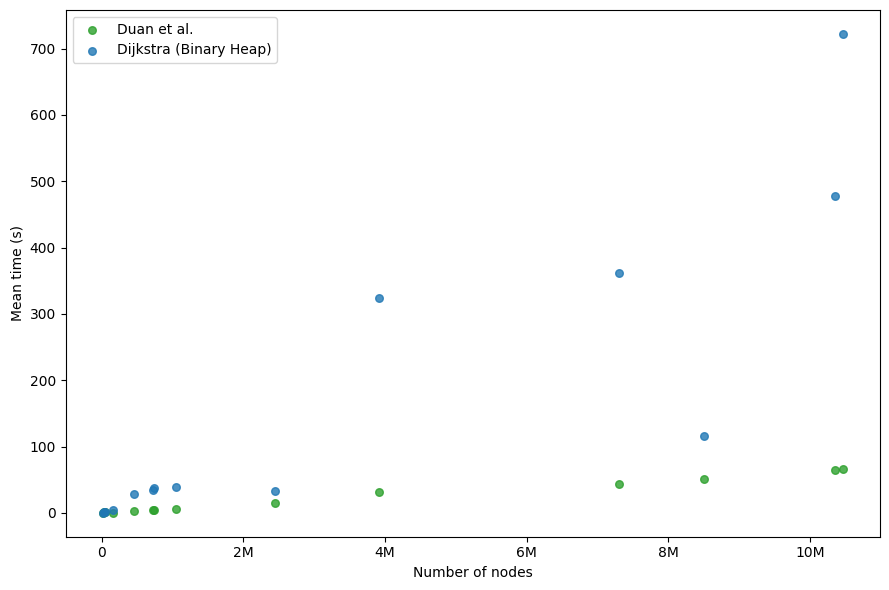

In [28]:
this_data = normalized_data_with_graph
plt.figure(figsize=(9, 6))

for method in filtered_methods:
    x = np.array([normalized_data_with_graph[a]["graph"]["nodes"] for a in this_data])
    y = np.array([normalized_data_with_graph[a]["methods"][method]["mean"]["point_estimate"] for a in
                  this_data])

    plt.scatter(x, y, label=algo_labels[method], s=30, alpha=0.8, c=colors.get(method, None))

plt.xlabel("Number of nodes")
plt.ylabel("Mean time (s)")
plt.gca().xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, p: f'{x / 1e6:.0f}M' if x >= 1e6 else f'{x / 1e3:.0f}k' if x >= 1e3 else f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, p: f'{x / 1e6:.0f}' if x >= 1e6 else f'{x / 1e3:.0f}' if x >= 1e3 else f'{x:.0f}'))

plt.legend()
plt.tight_layout()
plt.show()


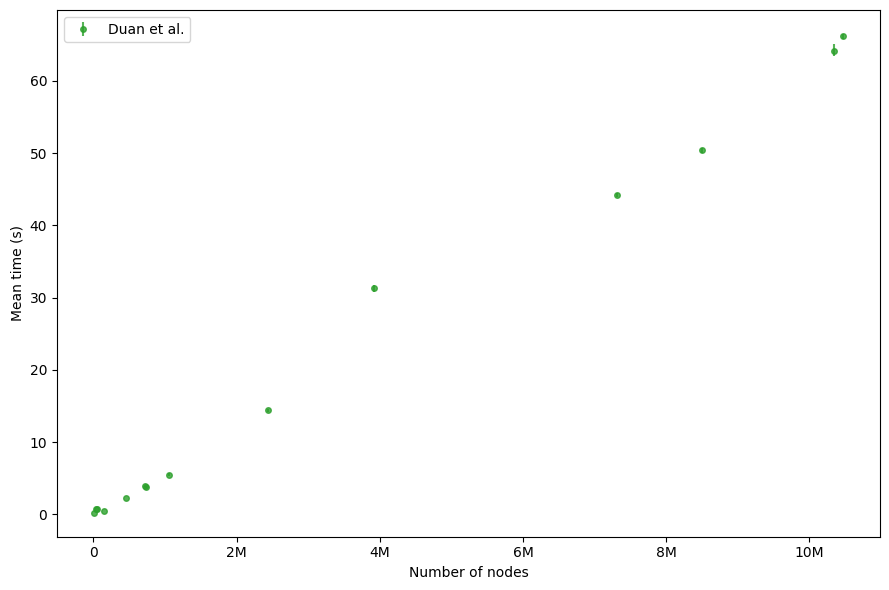

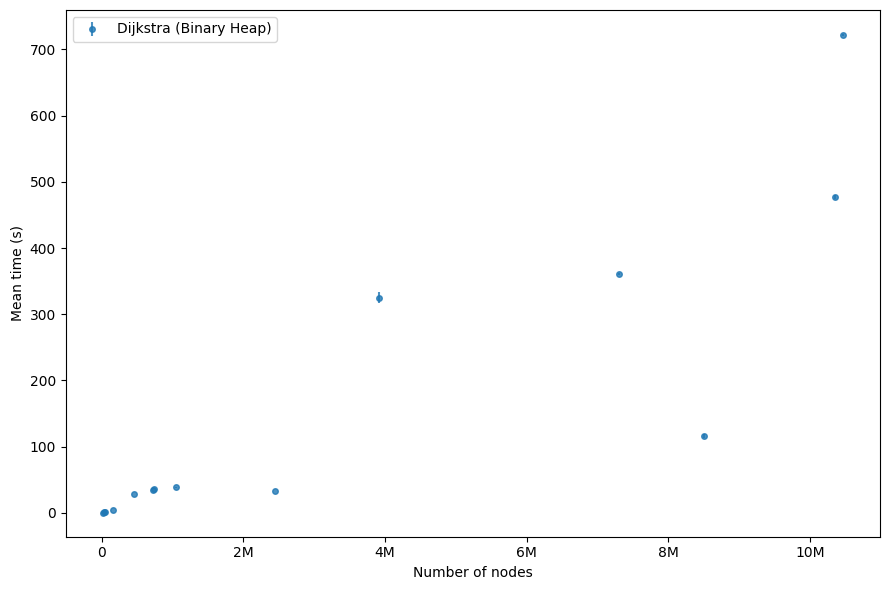

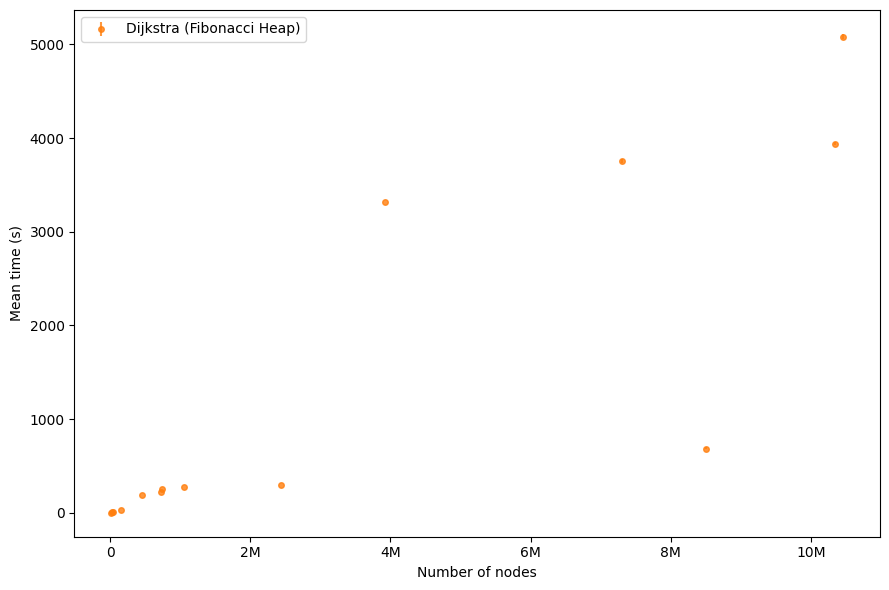

In [29]:
this_data = sm_data

for method in methods:
    plt.figure(figsize=(9, 6))
    x = np.array([normalized_data_with_graph[a]["graph"]["nodes"] for a in this_data])
    y = np.array([normalized_data_with_graph[a]["methods"][method]["mean"]["point_estimate"] for a in
                  this_data])
    lower_bounds = np.array(
        [normalized_data_with_graph[a]["methods"][method]["mean"]["confidence_interval"]["lower_bound"] for a in
         this_data])
    upper_bounds = np.array(
        [normalized_data_with_graph[a]["methods"][method]["mean"]["confidence_interval"]["upper_bound"] for a in
         this_data])
    yerr = np.array([y - lower_bounds, upper_bounds - y])
    plt.errorbar(x, y, yerr=yerr, fmt='o', label=algo_labels[method], markersize=4, alpha=0.8,
                 color=colors.get(method, None))
    plt.xlabel("Number of nodes")
    plt.ylabel("Mean time (s)")
    plt.gca().xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, p: f'{x / 1e6:.0f}M' if x >= 1e6 else f'{x / 1e3:.0f}k' if x >= 1e3 else f'{x:.0f}'))
    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, p: f'{x / 1e6:.0f}' if x >= 1e6 else f'{x / 1e3:.0f}' if x >= 1e3 else f'{x:.0f}'))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"graphs/{method}_w_errors.png")
    plt.show()


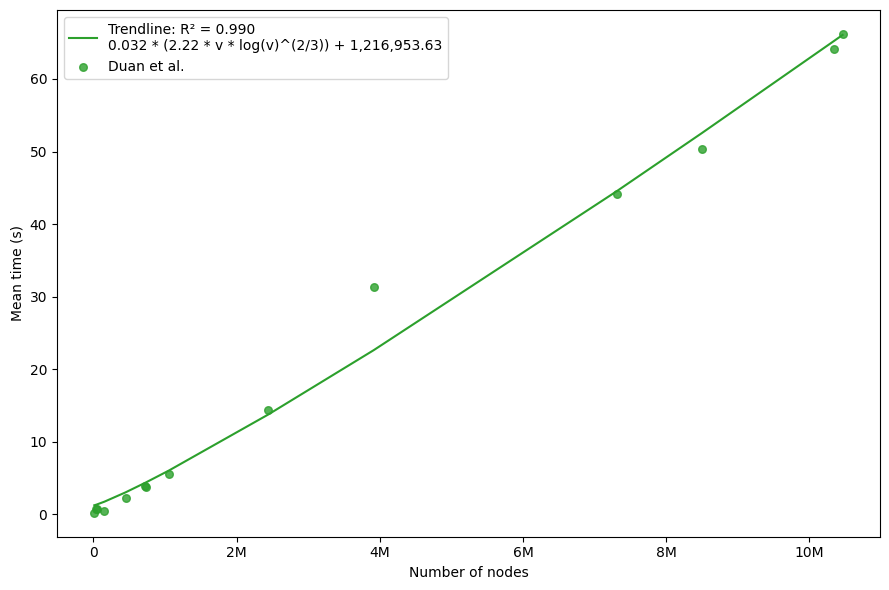

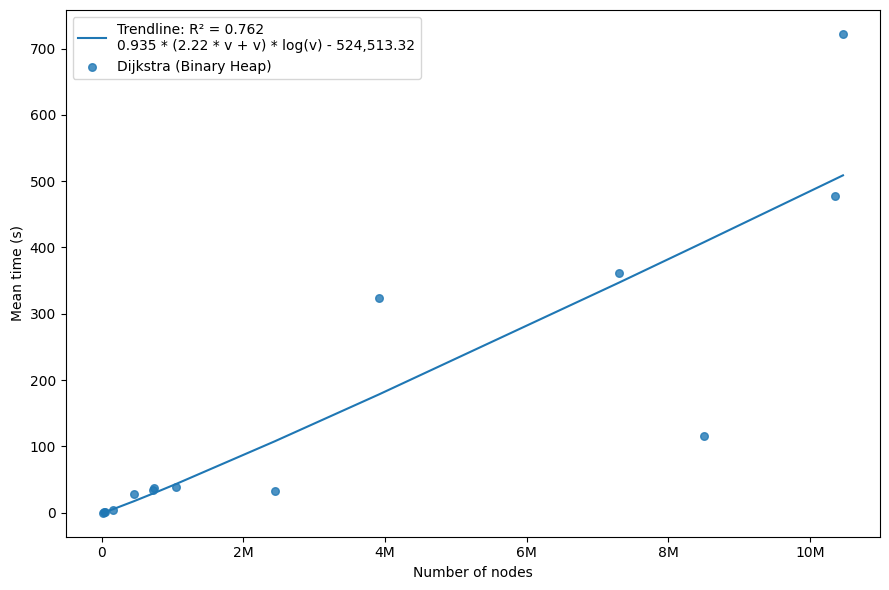

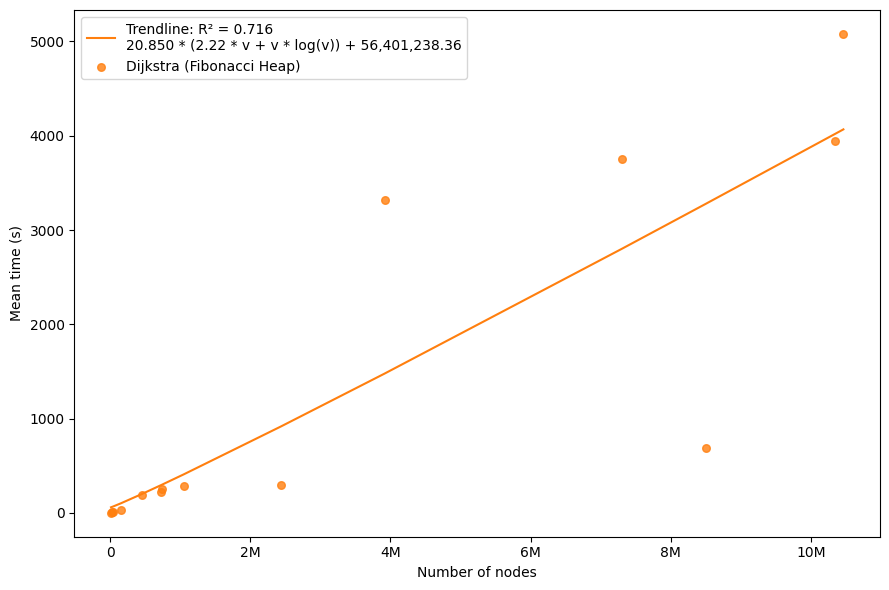

In [30]:
avg_degree = 2.22
mp = {
    'dijkstra': lambda v, a, b: a * (avg_degree * v + v) * np.log(v) + b,
    'dijkstra_fibonacci': lambda v, a, b: a * ((avg_degree * v) + v * np.log(v)) + b,
    'fast_sssp_sequential': lambda v, a, b: a * ((avg_degree * v) * np.log(v) ** 2 / 3) + b,
}


def sign_of(s: float) -> str:
    return "+" if s >= 0 else "-"


formulas = {
    'dijkstra': lambda a, b: f'{a:.3f} * ({avg_degree} * v + v) * log(v) {sign_of(b)} {np.abs(b):,.2f}',
    'dijkstra_fibonacci': lambda a, b: f'{a:.3f} * ({avg_degree} * v + v * log(v)) {sign_of(b)} {np.abs(b):,.2f}',
    'fast_sssp_sequential': lambda a, b: f'{a:.3f} * ({avg_degree} * v * log(v)^(2/3)) {sign_of(b)} {np.abs(b):,.2f}',
}


# Function to calculate R-squared
def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # R-squared value


this_data = normalized_data_with_graph
for method in methods:
    plt.figure(figsize=(9, 6))
    x = np.array([normalized_data_with_graph[a]["graph"]["nodes"] for a in this_data])
    y = np.array([normalized_data_with_graph[a]["methods"][method]["mean"]["point_estimate"] for a in
                  this_data])
    z = mp[method]

    fitted_params, pcov = curve_fit(z, x, y)

    # Generate points for the trendline
    x_sorted = np.sort(x)
    y_fitted = z(x_sorted, *fitted_params)

    # Calculate R-squared for the fit
    y_pred = z(x, *fitted_params)
    r_squared = calculate_r_squared(y, y_pred)

    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))

    formula = f"{formulas[method](fitted_params[0], fitted_params[1])}"
    plt.plot(x_sorted, y_fitted,
             label=f"Trendline: R² = {r_squared:.3f}\n" + formula,
             c=colors.get(method, None))
    plt.scatter(x, y, label=algo_labels[method], s=30, alpha=0.8, c=colors.get(method, None))
    plt.xlabel("Number of nodes")
    plt.ylabel("Mean time (s)")

    plt.gca().xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, p: f'{x / 1e6:.0f}M' if x >= 1e6 else f'{x / 1e3:.0f}k' if x >= 1e3 else f'{x:.0f}'))
    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, p: f'{x / 1e6:.0f}' if x >= 1e6 else f'{x / 1e3:.0f}' if x >= 1e3 else f'{x:.0f}'))

    plt.legend()
    plt.tight_layout()
    Path("graphs").mkdir(exist_ok=True)
    plt.savefig(f"graphs/{method}.png")
    plt.show()


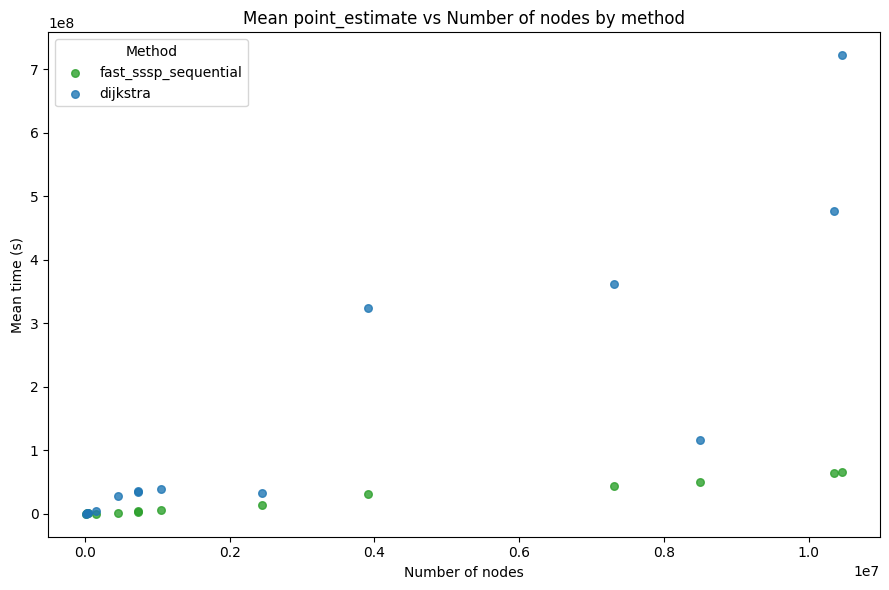

In [31]:
# Mean dijkstra vs fast graph
plt.figure(figsize=(9, 6))
for method in filtered_methods:
    x = [normalized_data_with_graph[a]["graph"]["nodes"] for a in sm_data]
    y = [normalized_data_with_graph[a]["methods"][method]["mean"]["point_estimate"] for a in sm_data]
    plt.scatter(x, y, label=method, s=30, alpha=0.8, c=colors.get(method, None))

plt.xlabel("Number of nodes")
plt.ylabel("Mean time (s)")
plt.title("Mean point_estimate vs Number of nodes by method")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

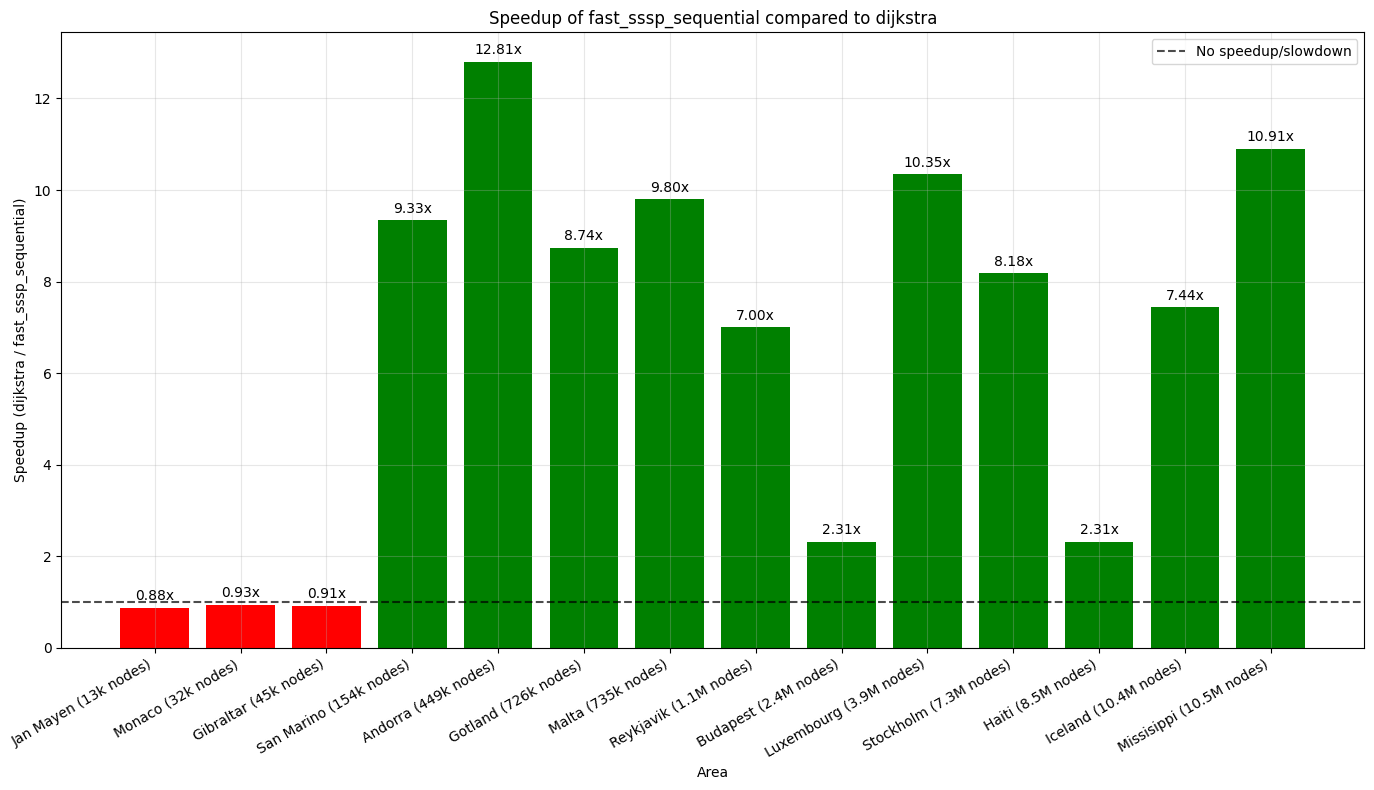

Jan Mayen (13k nodes): 0.88x slowdown
Monaco (32k nodes): 0.93x slowdown
Gibraltar (45k nodes): 0.91x slowdown
San Marino (154k nodes): 9.33x speedup
Andorra (449k nodes): 12.81x speedup
Gotland (726k nodes): 8.74x speedup
Malta (735k nodes): 9.80x speedup
Reykjavik (1.1M nodes): 7.00x speedup
Budapest (2.4M nodes): 2.31x speedup
Luxembourg (3.9M nodes): 10.35x speedup
Stockholm (7.3M nodes): 8.18x speedup
Haiti (8.5M nodes): 2.31x speedup
Iceland (10.4M nodes): 7.44x speedup
Missisippi (10.5M nodes): 10.91x speedup


In [32]:
import matplotlib.pyplot as plt

areas = []
speedups = []
labels = []

for area, data in normalized_data_with_graph.items():
    dijkstra_time = data["methods"]["dijkstra"]["mean"]["point_estimate"]
    fast_sssp_time = data["methods"]["fast_sssp_sequential"]["mean"]["point_estimate"]
    speedup = dijkstra_time / fast_sssp_time

    # Format node count in human readable format
    nodes = data["graph"]["nodes"]
    if nodes >= 1_000_000:
        node_label = f"{nodes / 1_000_000:.1f}M"
    elif nodes >= 1_000:
        node_label = f"{nodes / 1_000:.0f}k"
    else:
        node_label = str(nodes)

    areas.append(area)
    speedups.append(speedup)
    labels.append(f"{area.replace('_', ' ').title()} ({node_label} nodes)")

# Sort by number of nodes for better visualization
sorted_indices = sorted(range(len(areas)), key=lambda i: normalized_data_with_graph[areas[i]]["graph"]["nodes"])
sorted_areas = [areas[i] for i in sorted_indices]
sorted_speedups = [speedups[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

# Create the column graph
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(sorted_areas)), sorted_speedups, color=['green' if s > 1 else 'red' for s in sorted_speedups])

# Add speedup numbers above the bars
for i, (bar, speedup) in enumerate(zip(bars, sorted_speedups)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.1,
             f'{speedup:.2f}x', ha='center', va='bottom', fontsize=10)

# Add a horizontal line at y=1 to show no speedup/slowdown
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='No speedup/slowdown')

plt.xlabel('Area')
plt.ylabel('Speedup (dijkstra / fast_sssp_sequential)')
plt.title('Speedup of fast_sssp_sequential compared to dijkstra')
plt.xticks(range(len(sorted_areas)), sorted_labels, rotation=30, ha='right')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print speedup values for reference
for i, (area, speedup) in enumerate(zip(sorted_areas, sorted_speedups)):
    print(f"{sorted_labels[i]}: {speedup:.2f}x {'speedup' if speedup > 1 else 'slowdown'}")


In [33]:
# Load graph metrics
metric_files = list(Path("graph_metrics").iterdir())

# Load graph metrics from each file
graph_metrics = {}
for file_path in metric_files:
    # Extract map name from file name (remove _metrics.json)
    map_name = file_path.stem.replace('_metrics', '')
    
    # Load JSON data from file
    try:
        with open(file_path, 'r') as f:
            graph_metrics[map_name] = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

graph_metrics

# Create a function to process distribution data
def fix_distribution_data(metrics_data):
    for map_name, map_data in metrics_data.items():
        # Check if 'degrees' exists and contains 'distribution'
        if 'degrees' in map_data and 'distribution' in map_data['degrees']:
            distribution = map_data['degrees']['distribution']
            
            # Convert string keys to int and sort
            if isinstance(distribution, dict):
                new_distribution = {}
                # Convert string keys to integers
                for key, value in distribution.items():
                    try:
                        new_distribution[int(key)] = value
                    except ValueError:
                        # Keep as is if not convertible to int
                        new_distribution[key] = value
                
                # Create a sorted dictionary
                sorted_distribution = {k: new_distribution[k] for k in sorted(new_distribution.keys())}
                map_data['degrees']['distribution'] = sorted_distribution
    
    return metrics_data

# Apply the fix to the loaded graph metrics
graph_metrics = fix_distribution_data(graph_metrics)

graph_metrics

Error loading graph_metrics/malta_full_metrics.json: Expecting value: line 1 column 1 (char 0)
Error loading graph_metrics/.DS_Store: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


{'andorra_full': {'graph_info': {'file_path': 'data/andorra.osm.pbf',
   'vertices': 449273,
   'edges': 1043844},
  'degrees': {'min': 0,
   'max': 18,
   'median': 2.0,
   'average': 2.323406926300935,
   'distribution': {0: 4481,
    1: 3189,
    2: 369847,
    3: 7327,
    4: 55709,
    5: 397,
    6: 6820,
    7: 94,
    8: 866,
    9: 16,
    10: 420,
    11: 23,
    12: 63,
    13: 6,
    14: 9,
    15: 2,
    16: 3,
    18: 1}},
  'diameter': {'value': 1853,
   'is_estimated': False,
   'sample_size': None,
   'method': 'exact'},
  'average_path_length': {'value': 366.1227205732543,
   'skipped': False,
   'reason': None},
  'clustering': {'min': 0.0,
   'max': 1.0,
   'median': 0.0,
   'average': 0.009706076602383035,
   'nodes_calculated': 449273,
   'total_nodes': 449273},
  'execution': {'mode': 'FULL', 'total_time_seconds': 21817.059067458}},
 'haiti': {'graph_info': {'file_path': 'data/haiti.osm.pbf',
   'vertices': 8497106,
   'edges': 17186498},
  'degrees': {'min': 0,


In [34]:
# Create a LaTeX table with graph metrics information

# Prepare data for the table
table_data = []

# Keys we want to extract from each graph
metrics_to_extract = [
    ('graph_info.vertices', 'Vertices'),
    ('graph_info.edges', 'Edges'),
    ('degrees.average', 'Avg Degree'),
    ('degrees.max', 'Max Degree'),
    ('diameter.value', 'Diameter'),
    ('clustering.average', 'Clustering Coef')
]

# Process data for each map in graph_metrics
for map_name in graph_metrics.keys():
    row_data = {'Map': map_name.replace('_', ' ').title()}
    
    metrics = graph_metrics[map_name]
    
    # Extract nested values
    for key_path, label in metrics_to_extract:
        parts = key_path.split('.')
        value = metrics
        try:
            for part in parts:
                value = value[part]
            
            # Format the value based on its type
            if isinstance(value, (int)):
                row_data[label] = f"{value:,}"
            elif isinstance(value, float):
                row_data[label] = f"{value:.4f}"
            else:
                row_data[label] = str(value)
        except (KeyError, TypeError):
            row_data[label] = "N/A"
    
    table_data.append(row_data)

# Sort the table data by number of vertices (ascending)
table_data.sort(key=lambda x: int(x['Vertices'].replace(',', '')))

# Generate LaTeX table
latex_lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\caption{Graph Metrics Summary}",
    "\\begin{tabular}{|l|r|r|r|r|r|p|}",  # r for right-alignment of numeric columns
    "\\hline",
    "\\textbf{Map} & \\textbf{Vertices} & \\textbf{Edges} & \\textbf{Avg Degree} & \\textbf{Max Degree} & \\textbf{Diameter} & \\textbf{Network Clustering Coef} \\\\",
    "\\hline"
]

# Add data rows
for row in table_data:
    latex_lines.append(f"{row['Map']} & {row['Vertices']} & {row['Edges']} & {row['Avg Degree']} & {row['Max Degree']} & {row['Diameter']} & {row['Clustering Coef']} \\\\")

# Close the table
latex_lines.extend([
    "\\hline",
    "\\end{tabular}",
    "\\label{tab:graph_metrics}",
    "\\end{table}"
])

# Join all lines and print the LaTeX table
latex_table = "\n".join(latex_lines)
print(latex_table)

\begin{table}[htbp]
\centering
\caption{Graph Metrics Summary}
\begin{tabular}{|l|r|r|r|r|r|p|}
\hline
\textbf{Map} & \textbf{Vertices} & \textbf{Edges} & \textbf{Avg Degree} & \textbf{Max Degree} & \textbf{Diameter} & \textbf{Network Clustering Coef} \\
\hline
Jan Mayen & 13,230 & 29,786 & 2.2514 & 8 & 1,384 & 0.0005 \\
Monaco & 32,492 & 72,318 & 2.2257 & 20 & 233 & 0.0017 \\
Gibraltar & 44,639 & 100,284 & 2.2466 & 13 & 418 & 0.0013 \\
San Marino & 154,249 & 341,976 & 2.2170 & 10 & 629 & 0.0022 \\
Andorra Full & 449,273 & 1,043,844 & 2.3234 & 18 & 1,853 & 0.0097 \\
Andorra & 449,273 & 1,043,844 & 2.3234 & 18 & 1,713 & 0.0018 \\
Gotland Full & 725,852 & 1,634,818 & 2.2523 & 11 & 3,565 & 0.0010 \\
Gotland & 725,852 & 1,634,818 & 2.2523 & 11 & 3,436 & 0.0011 \\
Malta & 734,962 & 1,818,642 & 2.4745 & 14 & 754 & 0.0064 \\
Reykjavik & 1,051,160 & 2,241,396 & 2.1323 & 14 & 2,354 & 0.0015 \\
Budapest & 2,443,154 & 5,187,404 & 2.1232 & 23 & 393 & 0.0030 \\
Luxembourg & 3,916,210 & 10,664,130 &

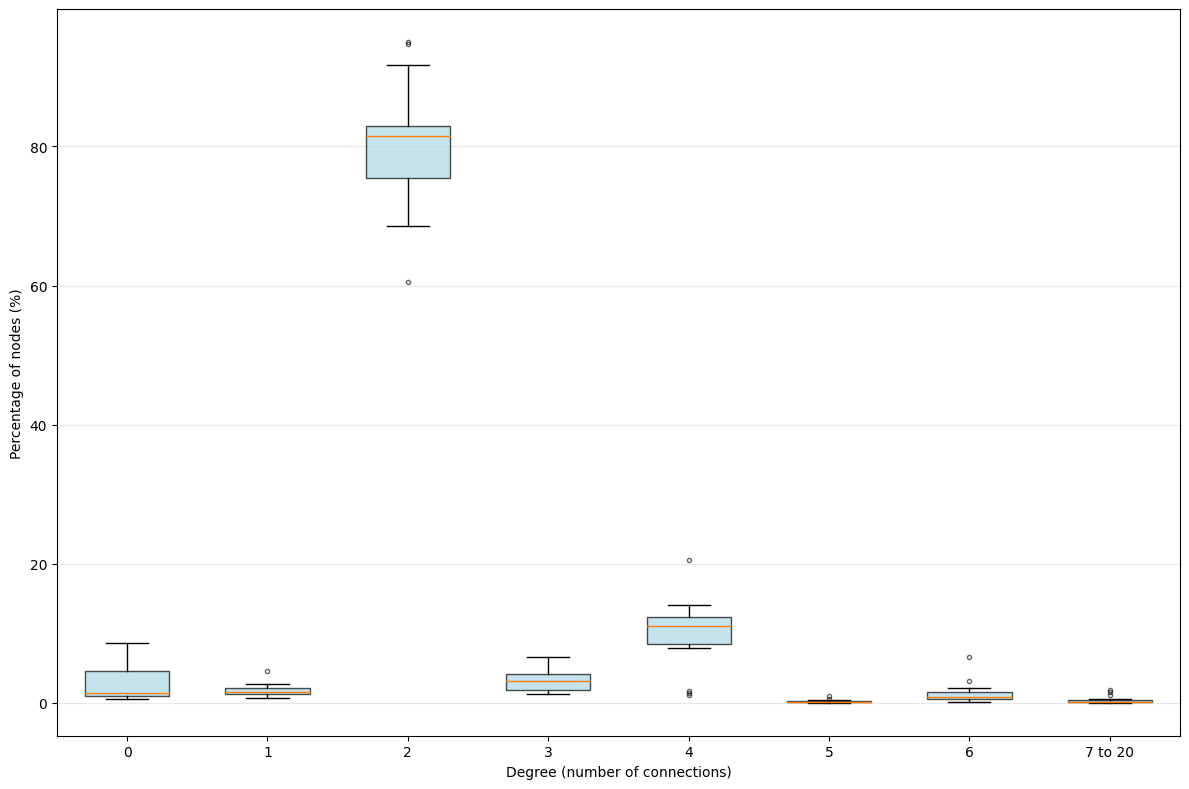

Degree Distribution Statistics Summary:
----------------------------------------------------------------------
Degree   Mean %     Std %      Maps     Min %    Max %   
----------------------------------------------------------------------
0        2.95       2.63       16       0.57     8.63    
1        1.78       0.93       16       0.71     4.61    
2        80.01      9.00       16       60.58    95.01   
3        3.39       1.62       16       1.22     6.58    
4        9.87       4.90       16       1.14     20.58   
5        0.22       0.25       15       0.02     0.95    
6        1.37       1.57       16       0.05     6.61    
7 to 20  0.42       0.57       16       0.01     1.85    


In [45]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Sort maps by node count
sorted_maps = sorted(graph_metrics.keys(), 
                    key=lambda m: graph_metrics[m]['graph_info']['vertices'])

# Collect all degree distributions and calculate statistics
degree_stats = {}

for map_name in sorted_maps:
    metrics = graph_metrics[map_name]
    
    if 'degrees' in metrics and 'distribution' in metrics['degrees']:
        distribution = metrics['degrees']['distribution']
        total_nodes = metrics['graph_info']['vertices']
        
        # Group degrees 7 and over together
        degree_7_plus_count = 0
        degree_7_plus_idx = "7 to 20"
        
        for degree_str, frequency_str in distribution.items():
            degree = int(degree_str)
            frequency = int(frequency_str)
            
            if degree >= 7:
                degree_7_plus_count += frequency
            else:
                percentage = (frequency / total_nodes) * 100
                
                if degree not in degree_stats:
                    degree_stats[degree] = []
                degree_stats[degree].append(percentage)
        
        # Add the combined 7+ category
        if degree_7_plus_count > 0:
            percentage_7_plus = (degree_7_plus_count / total_nodes) * 100
            if degree_7_plus_idx not in degree_stats:
                degree_stats[degree_7_plus_idx] = []
            degree_stats[degree_7_plus_idx].append(percentage_7_plus)

# Calculate statistics for each degree
degrees = [0, 1, 2, 3, 4, 5, 6, degree_7_plus_idx]  # Fixed order
means = []
stds = []
all_data = []

for degree in degrees:
    if degree in degree_stats:
        data = degree_stats[degree]
        means.append(np.mean(data))
        stds.append(np.std(data))
        all_data.append(data)
    else:
        means.append(0)
        stds.append(0)
        all_data.append([])

# Create the bar plot
plt.figure(figsize=(12, 8))

# Create box plot to show distribution, whiskers, and outliers
box_data = [degree_stats.get(d, []) for d in degrees]
positions = list(range(len(degrees)))

bp = plt.boxplot([data for data in box_data if len(data) > 0], 
                positions=[i for i, data in enumerate(box_data) if len(data) > 0], 
                widths=0.6, patch_artist=True,
                showfliers=True, flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.6})

# Customize box plot appearance
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

plt.xlabel('Degree (number of connections)')
plt.ylabel('Percentage of nodes (%)')
plt.grid(True, alpha=0.3, axis='y')

# Set x-axis labels
plt.xticks(positions, degrees)
plt.xlim(-0.5, len(degrees) - 0.5)

plt.tight_layout()
plt.savefig("graphs/degree_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("Degree Distribution Statistics Summary:")
print("-" * 70)
print(f"{'Degree':<8} {'Mean %':<10} {'Std %':<10} {'Maps':<8} {'Min %':<8} {'Max %':<8}")
print("-" * 70)

for i, degree in enumerate(degrees):
    if degree in degree_stats and len(degree_stats[degree]) > 0:
        data = degree_stats[degree]
        print(f"{str(degree):<8} {means[i]:<10.2f} {stds[i]:<10.2f} {len(data):<8d} "
              f"{min(data):<8.2f} {max(data):<8.2f}")
    else:
        print(f"{str(degree):<8} {'N/A':<10} {'N/A':<10} {'0':<8} {'N/A':<8} {'N/A':<8}")
